# Transfer Learning

Closely modeled after fast.ai's [NLP course](https://github.com/fastai/course-nlp).

### Settings & Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os.path
from fastai.text import *

### Data Preprocessing

In [3]:
path = "./data"

In [4]:
bs = 128  # Batch size

# If files have been saved, load them.
try:
    
    data_lm = load_data(path, 'data_lm_export.pkl', bs=bs)
    data_clas = load_data(path, 'data_clas_export.pkl', bs=bs)
    data_bwd = load_data(path, 'data_lm_export.pkl', bs=bs, backwards=True)
    data_clas_bwd = load_data(path, 'data_clas_export.pkl', bs=bs, backwards=True)
    print("Saved files loaded successfully...\n")
    
except:
    
    print("Files not found. Creating data files...\n")
    
    # Language model data
    data_lm = TextLMDataBunch.from_csv(path, 'preprocessed_data.csv', text_cols='tweet', bs=bs)
    # Classifier model data
    data_clas = TextClasDataBunch.from_csv(path, 'preprocessed_data.csv', text_cols='tweet', label_cols='class', 
                                           vocab = data_lm.vocab, bs=bs)
    
    # Save files
    data_lm.save('data_lm_export.pkl')
    data_clas.save('data_clas_export.pkl')
    
    # Load backwards data
    data_bwd = load_data(path, 'data_lm_export.pkl', bs=bs, backwards=True)
    data_clas_bwd = load_data(path, 'data_clas_export.pkl', bs=bs, backwards=True)

Saved files loaded successfully...



In [5]:
data_lm.show_batch()

idx,text
0,and fucking answer me before i smack the shit outta you and your faggot aunt . xxbos xxup rt xxup mentionhere : xxup lol at my mentions xxmaj liberal1 : you 're a racist bitch xxmaj xxunk : yeah kill all whites ( xxmaj liberal1 is white ) xxmaj liberal1 : xxmaj not … xxbos xxmaj some people are so constantly xxunk . xxmaj it 's so unattractive . xxmaj
1,"in other countries , yet in this country it 's a reference to somebody .. xxmaj like "" who 's this cunt ? "" xxbos xxup mentionhere pussy xxbos xxmaj this bitch in here putting long lashes on like a xxunk xxbos xxup mentionhere "" do n't get head from hoes with xxunk "" xxup mentionhere xxbos xxup mentionhere you got some more hoe xxbos xxup rt xxup mentionhere :"
2,"blunts straight bumpin # xxup xxunk this hoe on some other shit bro i got mind fucked like when black xxunk betrayed xxbos aaa xxrep 5 h my internet has died , for the whole weekend i 'm told , just in time to teach me the true spirit of christmas . fucking cunt . xxbos xxup rt xxup mentionhere : xxmaj couple a , b 's , c 's"
3,"xxbos xxup mentionhere and xxup mentionhere are faggots . xxmaj xxunk . xxbos xxup mentionhere xxup mentionhere man fck dat tranny xxrep 4 . xxmaj xxunk man ass nigga xxrep 4 . xxbos xxup mentionhere shut up lizard faggot nigger cunt xxbos “ xxup mentionhere : “ xxup mentionhere : xxup mentionhere u a regular nig , u played out b ” lol i m a b xxmaj ig xxunk"
4,"# xxunk pick in recent mock drafts . xxup draft xxup xxunk : xxup urlhere xxup urlhere # 8230 ; xxbos xxup mentionhere xxmaj maybe xxmaj xxunk xxmaj ann , xxmaj xxunk xxmaj xxunk , xxmaj nurse xxmaj xxunk , xxmaj charlie xxmaj chainsaws , & & xxmaj mama xxmaj xxunk should be their own team ? xxmaj next time in xxunk xxunk d xxbos xxup mentionhere xxup mentionhere xxup"


In [6]:
data_clas.show_batch()

text,target
xxbos xxup rt xxup mentionhere : xxup rt if you like xxup xxunk xxup xxunk xxup ptv xxup xxunk xxup sws xxup atl xxup xxunk xxup aa xxup xxunk xxup xxunk xxup xxunk xxup xxunk xxup xxunk xxup pe xxup bvb xxup xxunk xxup bc xxup xxunk xxup xxunk xxup xxunk xxup gd xxup xxunk xxup aa xxup xxunk xxup fob f …,2
xxbos xxup rt xxup mentionhere : xxup rt if you listen to these bands 😊 xxup xxunk xxup ptv xxup sws xxup atl xxup bvb xxup xxunk xxup xxunk xxup xxunk xxup fob xxup aa xxmaj xxunk xxunk xxup xxunk xxup xxunk xxup xxunk xxup xxunk xxmaj follow me & & xxunk …,2
xxbos xxup rt xxup mentionhere : xxup if a xxup single xxup wasp xxup could xxup read xxup these # xxunk xxup tweets xxup there xxup could xxup be a xxup peace xxup xxunk xxup between xxup wasps xxup and xxup man xxup but xxup wasps xxup are …,2
xxbos xxup rt xxup mentionhere : xxmaj da bitch got scared and could n't take it no mo but ya boy was xxunk fo dat 😕 😂 😂 “ xxup mentionhere : 😂 😭 😂 😭 😂 😭 😂 xxunk n xxrep 8 o xxup urlhere # 8230 ;,1
"xxbos xxup rt xxup mentionhere : xxmaj me : xxmaj you 're a hoe xxmaj hoe : xxmaj you was n't saying that xxmaj august 12 , 2014 at xxunk xxup pm xxmaj me : xxmaj well you 're a hoe today on xxmaj october 1st 2014 at …",1


### Fine-Tuning (Forward)

In [7]:
# Load language model and find good LR
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=1).to_fp16(clip=0.1)
learn_lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


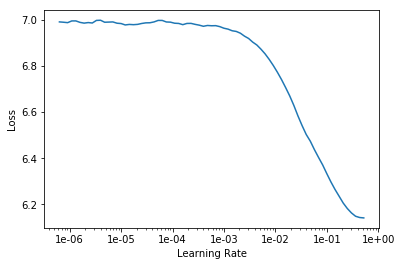

In [8]:
learn_lm.recorder.plot(skip_end=15)

In [9]:
# Fit one epoch
learn_lm.fit_one_cycle(1, 5e-2,  moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.893182,4.170970,0.271019,00:10


In [10]:
# Unfreeze all layers and fit five epochs
learn_lm.unfreeze()
learn_lm.fit_one_cycle(5, slice(1e-4,1e-2), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,4.239388,4.041652,0.287119,00:13
1,4.109244,3.925340,0.298698,00:13
2,3.955872,3.870889,0.304669,00:13
3,3.802833,3.847037,0.307450,00:13
4,3.690902,3.848467,0.307933,00:13


In [11]:
learn_lm.save_encoder('fwd_enc')

### Fine-Tuning (Backward)

In [12]:
# Similarly, but for a backwards LM model
learn_bwd = language_model_learner(data_lm, AWD_LSTM, drop_mult=1).to_fp16(clip=0.1)
learn_bwd.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [13]:
learn_bwd.fit_one_cycle(1, 5e-2,  moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.153151,4.251572,0.259784,00:10


In [14]:
learn_bwd.unfreeze()
learn_bwd.fit_one_cycle(5, slice(1e-4,1e-2), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,4.397674,4.048745,0.282980,00:13
1,4.218276,3.948424,0.288793,00:13
2,4.019299,3.839787,0.307059,00:13
3,3.834281,3.810404,0.310658,00:13
4,3.698104,3.809005,0.311728,00:13


In [15]:
learn_bwd.save_encoder('bwd_enc')

### Classifier (Forward)

In [16]:
# Load a classifier model and the weights of encoder layers.
learn_class = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, pretrained=False)
learn_class.load_encoder('fwd_enc')
learn_class.freeze() # Freeze all but last layer

In [17]:
learn_class.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


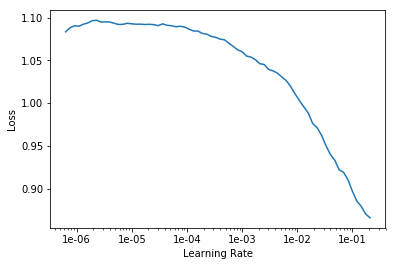

In [18]:
learn_class.recorder.plot(skip_end=15)

In [19]:
lr = 1e-1
learn_class.fit_one_cycle(1, lr, moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.499330,0.448323,0.838007,00:07


In [20]:
learn_class.save('1st')

In [21]:
# Freeze all but two last layers
learn_class.freeze_to(-2)
lr /= 2
learn_class.fit_one_cycle(1, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.382308,0.315083,0.886625,00:09


In [22]:
learn_class.save('2nd')

In [23]:
# Freeze all but three last layers
learn_class.freeze_to(-3)
lr /= 2
learn_class.fit_one_cycle(1, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.305632,0.273235,0.902360,00:13


In [24]:
learn_class.save('3rd')

In [25]:
# Unfreeze all layers
learn_class.unfreeze()
lr /= 5
learn_class.fit_one_cycle(2, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.260921,0.272525,0.899738,00:17
1,0.229937,0.270259,0.906193,00:17


In [26]:
learn_class.save('fwd_clas')

### Classifier (Backward)

In [27]:
# Likewise, but now for a backwards classifier
learn_class_bwd = text_classifier_learner(data_clas_bwd, AWD_LSTM, drop_mult=0.5, pretrained=False)
learn_class_bwd.load_encoder('bwd_enc')
learn_class_bwd.freeze()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


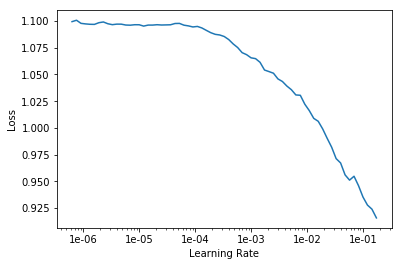

In [28]:
learn_class_bwd.lr_find()
learn_class_bwd.recorder.plot(skip_end=15)

In [29]:
lr = 1e-1
learn_class_bwd.fit_one_cycle(1, lr, moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.527991,0.502802,0.798265,00:07


In [30]:
learn_class_bwd.save('1st_bwd')

In [31]:
learn_class_bwd.freeze_to(-2)
lr /= 2
learn_class_bwd.fit_one_cycle(1, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.383196,0.338777,0.872504,00:09


In [32]:
learn_class_bwd.save('2nd_bwd')

In [33]:
learn_class_bwd.freeze_to(-3)
lr /= 2
learn_class_bwd.fit_one_cycle(1, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.333193,0.279756,0.902562,00:14


In [34]:
learn_class_bwd.save('3rd_bwd')

In [35]:
learn_class_bwd.unfreeze()
lr /= 5
learn_class_bwd.fit_one_cycle(3, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.290174,0.269414,0.905790,00:16
1,0.248511,0.265037,0.903571,00:17
2,0.220894,0.266085,0.906798,00:15


In [36]:
learn_class_bwd.save('bwd_clas')

### Ensemble

In [37]:
# Load bidirectional classifiers
learn_class = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, pretrained=False)
learn_class.load('fwd_clas');

learn_class_bwd = text_classifier_learner(data_clas_bwd, AWD_LSTM, drop_mult=0.5, pretrained=False)
learn_class_bwd.load('bwd_clas');

In [38]:
# Get predictions
pred_fwd,lbl_fwd = learn_class.get_preds(ordered=True)
pred_bwd,lbl_bwd = learn_class_bwd.get_preds(ordered=True)

# Average predictions
final_preds = (pred_fwd+pred_bwd)/2
y_pred = final_preds.data.max(1)[1].numpy()

In [39]:
from sklearn.metrics import f1_score
from classifier_utils import plot_confusion_matrices

@np_func
def f1(inp,targ): return f1_score(targ, np.argmax(inp, axis=-1), average="weighted")

print(accuracy(final_preds, lbl_fwd), f1(final_preds, lbl_fwd))

tensor(0.9088) tensor(0.9014)


Confusion matrix, without normalization
Normalized confusion matrix


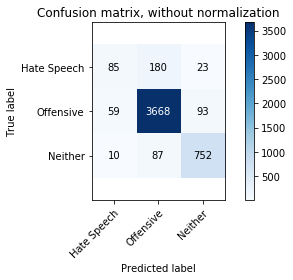

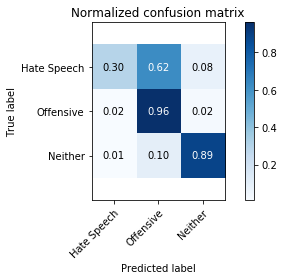

In [40]:
plot_confusion_matrices(lbl_fwd, y_pred)